In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer

from src.config import DADOS_ORIGINAIS, DADOS_TRATADOS
from src.graficos import PALETTE, SCATTER_ALPHA
  
sns.set_theme(palette='bright')

In [2]:
data = load_breast_cancer()

df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target

df.to_parquet(DADOS_ORIGINAIS)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
col_num = df.drop(columns=['target']).columns

# Downcast das colunas float
df[col_num] = df[col_num].apply(pd.to_numeric, downcast='float')

# Conversão das colunas categóricas
df['target'] = pd.to_numeric(df['target'], downcast='integer')

# Resultado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float32
 1   mean texture             569 non-null    float32
 2   mean perimeter           569 non-null    float32
 3   mean area                569 non-null    float32
 4   mean smoothness          569 non-null    float32
 5   mean compactness         569 non-null    float32
 6   mean concavity           569 non-null    float32
 7   mean concave points      569 non-null    float32
 8   mean symmetry            569 non-null    float32
 9   mean fractal dimension   569 non-null    float32
 10  radius error             569 non-null    float32
 11  texture error            569 non-null    float32
 12  perimeter error          569 non-null    float32
 13  area error               569 non-null    float32
 14  smoothness error         5

In [5]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289650,91.969032,654.889038,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261215,880.583130,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524048,4.301038,24.298983,351.914093,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146256,33.602535,569.356873,0.022832,0.157337,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790001,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.199997,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.169998,420.299988,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110001,515.299988,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.239998,551.099976,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660004,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.799999,104.099998,782.700012,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.719999,125.400002,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110001,39.279999,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540001,251.199997,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [6]:
df['target'].value_counts(normalize=True)

target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

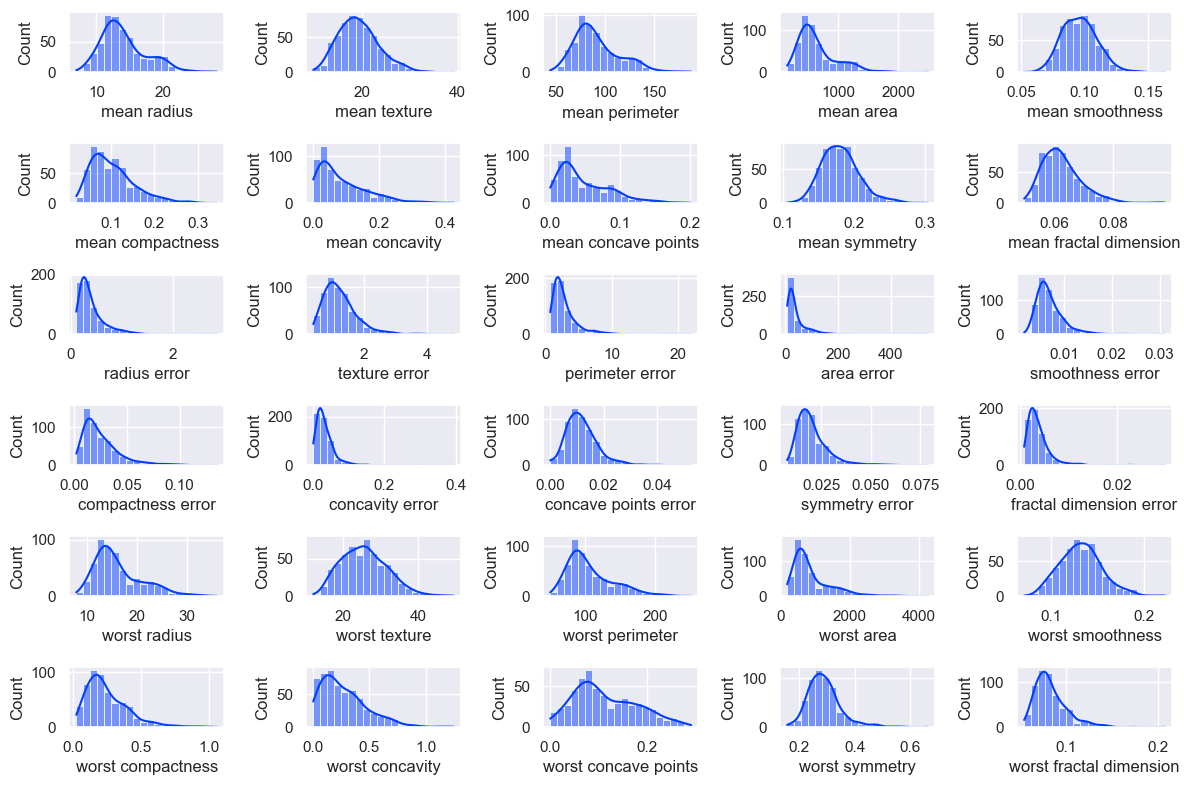

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(df[col_num]):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=20)


plt.tight_layout()
plt.show()

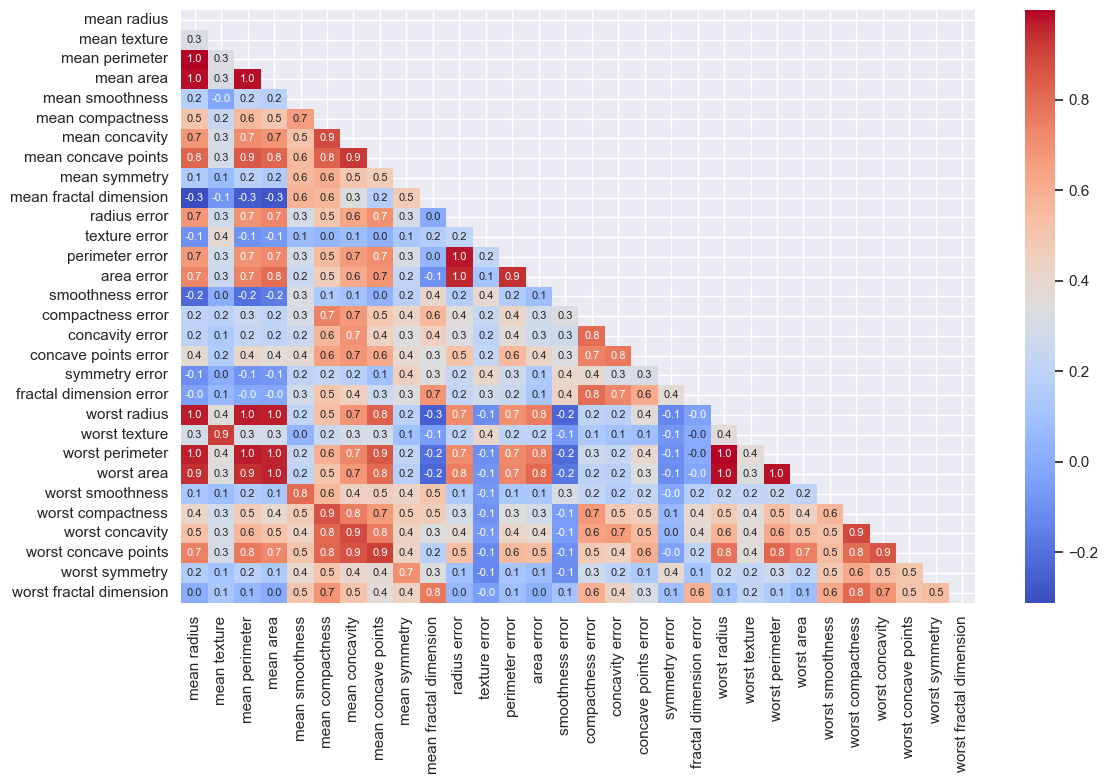

In [8]:
correl_matrix = np.triu(df[col_num].corr())

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(df[col_num].corr(), mask=correl_matrix, annot=True, annot_kws={"size": 8}, fmt=".1f", ax=ax, cmap=PALETTE)

plt.tight_layout()
plt.show()

In [9]:
df.to_parquet(DADOS_TRATADOS)